En esta ocasión trabajaré con una base de datos que fue generada en el semestre de Otoño 2022
en una clase de Sistemas Digitales en la Universidad de Monterrey. En dicha materia, cada
semana se entregan actividades y la bandeja de entrega se cierra cada domingo a medianoche.
El profesor dice que, con su experiencia impartiendo esta clase, tiene la sospecha de que entre más cerca de la hora
de cierre de la bandeja se entrega la tarea, peor la calificación en la misma. 
\
Averiguaremos si podemos confirmar o rechazar esta hipótesis.


Antes de empezar, cabe aclarar que, tras analizar manualmente la base de datos "A1.6 Tiempo de Entrega.csv", se identificaron valores nulos y/o inválidos. Para solucionarlo, primero utilizamos la función to_numeric para convertir a número todas las entradas y así forzar a que cualquier valor no válido (caracteres, espacios en blanco o símbolos) quede como vacío. Posteriormente, eliminamos estas observaciones con dropna, ya que representan una cantidad poco significativa respecto al total.

En cuanto a los outliers, en lugar de simplemente quitar el valor negativo y el de casi 5000 horas de anticipación (los cuales evidentemente no son realistas), decidimos aplicar la prueba de Tukey. , eliminando de manera objetiva aquellos valores extremos que se salen del patrón general de la muestra. Con ello, garantizamos que el modelo se concentre en los datos representativos y no en observaciones atípicas que podrían distorsionar el análisis.

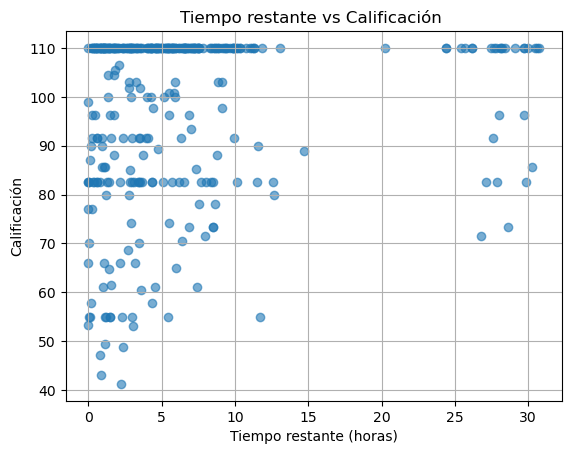

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("A1.6 Tiempo de Entrega.csv")
df["Tiempo"] = pd.to_numeric(df["Tiempo"], errors="coerce")
df["Calificacion"] = pd.to_numeric(df["Calificacion"], errors="coerce")

df = df.dropna()

#tukey
def eliminar_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    li = Q1 - 1.5 * IQR   # límite inferior
    ls = Q3 + 1.5 * IQR   # límite superior
    return df[(df[col] >= li) & (df[col] <= ls)], li, ls

df, li_t, ls_t = eliminar_outliers(df, "Tiempo")
df, li_c, ls_c = eliminar_outliers(df, "Calificacion")

plt.scatter(df["Tiempo"], df["Calificacion"], alpha=0.6)
plt.title("Tiempo restante vs Calificación ")
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación")
plt.grid(True)
plt.show()


La gráfica de dispersión muestra que los datos no siguen una relación lineal simple ya que hay muchos estudiantes con calificaciones de 110 en diferentes tiempos, lo que genera una curva confore aumenta el tiempo restante.  

Debido a esto, considero que un modelo de regresión polinomial probablemente será el más adecuado ya que nos permite encontrar relaciones no lineales entre el tiempo de entrega y la calificación.

Mi predicción es que la regresión polinomial mostrará una tendencia general donde los estudiantes que entregan con más anticipación tienen mejores calificaciones, pero con cierta variabilidad.


Ahora dividiremos los datos en datos de entrenamiento y prueba, con una relación de 70/30

In [2]:
from sklearn.model_selection import train_test_split

X = df.Tiempo
Y = df.Calificacion

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

print("\n--Entrenamiento--")
print("Promedio Tiempo - :", X_train.mean())
print("Promedio Calificación - Entrenamiento:", Y_train.mean())
print("\n--Prueba--")
print("Promedio Tiempo - Prueba:", X_test.mean())
print("Promedio Calificación - Prueba:", Y_test.mean())




--Entrenamiento--
Promedio Tiempo - : 6.292971743349138
Promedio Calificación - Entrenamiento: 97.66281439655174

--Prueba--
Promedio Tiempo - Prueba: 6.86903055555
Promedio Calificación - Prueba: 97.4644356


Los resultados muestran que los promedios de tiempo y calificación en el conjunto de entrenamiento y prueba son bastante similares.  
Esto es bueno porque significa que la partición de los datos no introduce un sesgo fuerte, y podemos confiar en que la medición sobre el conjunto de prueba reflejará de manera adecuada la capacidad de generalización del modelo.  

Ahora entrenaremos un modelo de regresión polinomial de segundo grado.
Este tipo de modelo nos permitirá capturar curvaturas en los datos, lo cual es útil considerando que algunos estudiantes entregan temprano y obtienen buenas calificaciones, mientras que otros entregan tarde y presentan más variabilidad.


In [3]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train.values.reshape(-1, 1))
X_test_poly = poly.transform(X_test.values.reshape(-1, 1))

model_poly = sm.OLS(Y_train, sm.add_constant(X_train_poly)).fit()

print(model_poly.summary())


                            OLS Regression Results                            
Dep. Variable:           Calificacion   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.030
Date:                Sun, 31 Aug 2025   Prob (F-statistic):             0.0503
Time:                        19:54:30   Log-Likelihood:                -982.19
No. Observations:                 232   AIC:                             1970.
Df Residuals:                     229   BIC:                             1981.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.2226      2.114     44.092      0.0

Dentro de los resultados podemos notar que el término lineal (x1) tiene un coeficiente positivo, lo que significa que en cuanto más antes se entregue la tarea, probablemente será mejor la calificación obtenida. Asimismo, podemos notar cómo es que ambos coeficientes son estadísticamente significativos con un valor de p < 0.05.  

En conclusión, los resultados apoyan la hipótesis de que entregar con más anticipación se asocia con una mejor calificación, aunque la magnitud del efecto es pequeña y el modelo explica solo una fracción limitada de la variabilidad, lo que podemos notar mediante el valor de R2, siendo de aproximadamente 0.026.


A continuación, aplicaremos regresión segmentada, dividiendo los datos en segmentos y ajustando un modelo cuadrático en cada uno.

La idea es que los estudiantes que entregan con poco tiempo restante podrían comportarse distinto a los que entregan con muchas horas de anticipación, y un único polinomio no captura esa variación.

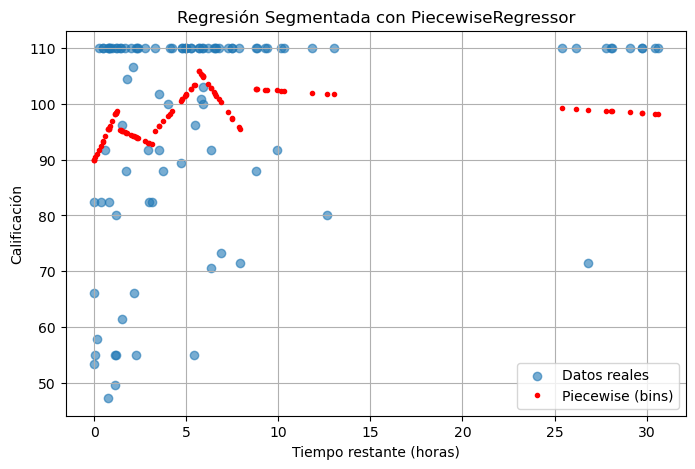

In [4]:
from mlinsights.mlmodel import PiecewiseRegressor

ms = PiecewiseRegressor("bins").fit(X_train.values.reshape(-1,1), Y_train)

plt.figure(figsize=(8,5))
plt.scatter(X_test, Y_test, label="Datos reales", alpha=0.6)

yHat_ms = ms.predict(X_test.values.reshape(-1,1))
plt.plot(X_test, yHat_ms, "r.", label="Piecewise (bins)")

plt.title("Regresión Segmentada con PiecewiseRegressor")
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación")
plt.legend()
plt.grid(True)
plt.show()


El modelo segmentado divide los datos en distintos tramos y ajusta regresiones cuadráticas dentro de cada uno. En la gráfica se observa que capta hasta cierto punto la tendencia general, pero al mismo tiempo se nota algo sobreajustado a los valores de cada segmento, lo que le resta capacidad de generalización frente a nuevos datos.

Ahora aplicaremos un modelo de KNN, el cual estima la calificación de un estudiante con base en los vecinos más cercanos en el conjunto de entrenamiento.  


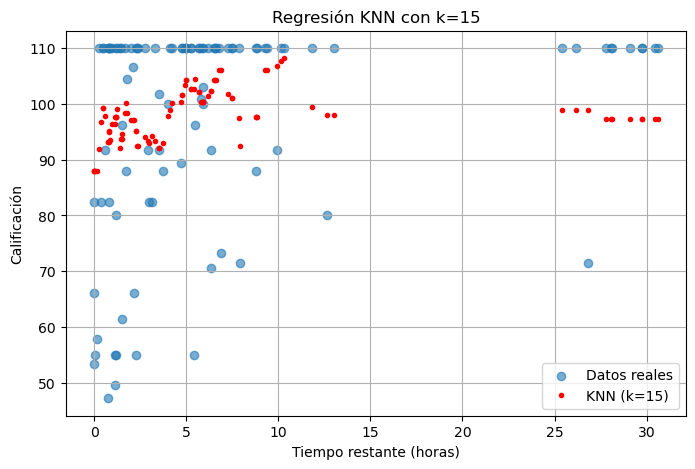

In [5]:
from sklearn.neighbors import KNeighborsRegressor as KNN

mk = KNN(n_neighbors=15).fit(X_train.values.reshape(-1,1), Y_train)

yHat_mk = mk.predict(X_test.values.reshape(-1,1))

plt.figure(figsize=(8,5))
plt.scatter(X_test, Y_test, label="Datos reales", alpha=0.6)
plt.plot(X_test, yHat_mk, "r.", label="KNN (k=15)")
plt.title("Regresión KNN con k=15")
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación")
plt.legend()
plt.grid(True)
plt.show()


El modelo KNN con k=15 muestra una curva más suave que sigue la tendencia general de los datos, donde en entregas cercanas al límite de entrega, las calificaciones tienden a ser más bajas, mientras que conforme aumenta el tiempo de anticipación, las calificaciones promedio son más altas y se estabilizan cerca del valor máximo (110).  

Comparado con la regresión polinomial y segmentada, KNN tiene la ventaja de adaptarse a los datos sin necesidad de asumir una forma específica (lineal o cuadrática).  
Sin embargo, la elección del valor de k es muy importante, por lo que para obtener un balance razonable, se determinó que un valor de k=15 sería adecuado para capturar la tendencia sin seguir demasiado el ruido.


Ahora compararemos el desempeño de los tres modelos entrenados.


Para esto, calcularemos el RSE en los datos de prueba y analizaremos cuál modelo se adapta mejor a estos.


In [6]:
import numpy as np

yHat_poly = model_poly.predict(sm.add_constant(X_test_poly))
RSS_poly = np.sum((np.array(Y_test) - yHat_poly) ** 2)
RSE_poly = np.sqrt(RSS_poly / (len(Y_test) - 1))
print("RSE Regresión Polinomial:", RSE_poly)

yHat_segmented = ms.predict(X_test.values.reshape(-1,1))
RSS_seg = np.sum((np.array(Y_test) - yHat_segmented) ** 2)
RSE_seg = np.sqrt(RSS_seg / (len(Y_test) - 1))
print("RSE Regresión Segmentada:", RSE_seg)

yHat_knn = mk.predict(X_test.values.reshape(-1,1))
RSS_knn = np.sum((np.array(Y_test) - yHat_knn) ** 2)
RSE_knn = np.sqrt(RSS_knn / (len(Y_test) - 1))
print("RSE Regresión KNN:", RSE_knn)


RSE Regresión Polinomial: 18.124993866793485
RSE Regresión Segmentada: 17.970448511980894
RSE Regresión KNN: 17.717168378740833


Entre los tres modelos probados, el KNN presenta el menor error, con un valor RSE de aproximadamente 17.7, lo que lo convierte en el más preciso en este caso. Aunque la diferencia respecto a la regresión segmentada y polinomial es pequeña, KNN tiene la ventaja de adaptarse de manera flexible a la forma de los datos sin imponer una estructura global como ocurre en los modelos polinomiales. Esto le permite capturar algunos patrones locales con mayor detalle, manteniendo un buen balance entre error y generalización. Por estas razones, KNN se considera la mejor opción en este caso.

Finalmente, graficaremos en una misma gráfica los datos reales junto con las predicciones generadas por los tres modelos.  
Esto nos permitirá comparar visualmente su desempeño y observar las diferencias en cómo cada modelo se ajusta a los datos.


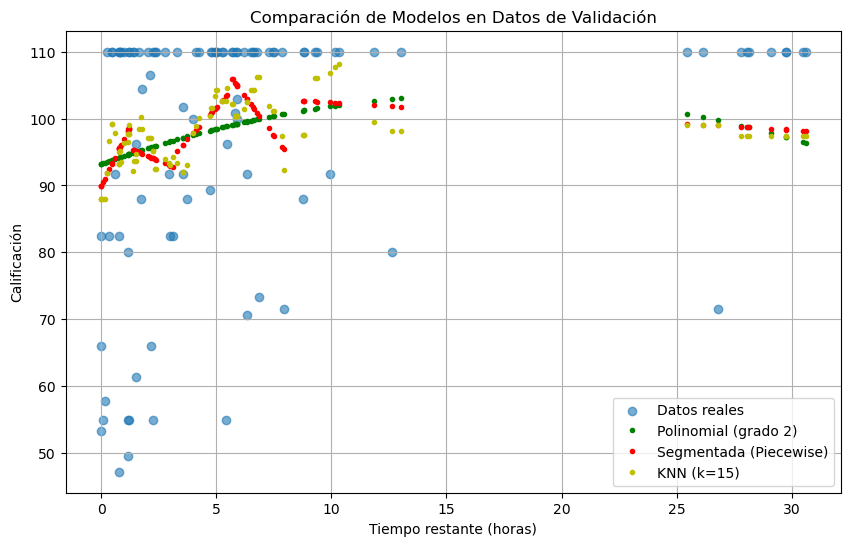

In [7]:
# Predicciones de los tres modelos
yHat_poly = model_poly.predict(sm.add_constant(X_test_poly))
yHat_segmented = ms.predict(X_test.values.reshape(-1,1))
yHat_knn = mk.predict(X_test.values.reshape(-1,1))

# Gráfica comparativa
plt.figure(figsize=(10,6))
plt.scatter(X_test, Y_test, label="Datos reales", alpha=0.6)

plt.plot(X_test, yHat_poly, "g.", label="Polinomial (grado 2)")
plt.plot(X_test, yHat_segmented, "r.", label="Segmentada (Piecewise)")
plt.plot(X_test, yHat_knn, "y.", label="KNN (k=15)")

plt.title("Comparación de Modelos en Datos de Validación")
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación")
plt.legend()
plt.grid(True)
plt.show()


En la gráfica se observa que los tres modelos logran capturar la tendencia general de los datos.  
La regresión polinomial muestra una curva global más suave, mientras que la regresión segmentada se adapta por tramos y llega a sobreajustar en algunos segmentos. El modelo KNN produce predicciones más flexibles y locales, ajustándose con mayor detalle al patrón de los datos de prueba.  
Asimismo, las diferencias entre ellos no son drásticas, lo que coincide con los valores de RSE obtenidos previamente, que fueron muy similares.
